### **Task 2 - Testing if the store layout changes made a real difference to sales**

##### **What are we doing?**

Julia, the manager in charge of chip sales, wants to know if the new store layout in stores 77, 86, and 88 actually helped sell more chips. To figure this out, we need to compare these 3 trial stores with similar stores that didn't have the new layout (these are called control stores).

We'll look at:
* How much money each store made
* How many customers came to each store  
* How many times each customer visited

Then we'll compare the trial stores with the control stores to see if the new layout really made a difference!

In [123]:
## Libraries
# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Satistics
from statistics import stdev
from scipy.stats import t
import matplotlib.dates as mdates

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cleaned data from Task 1
data = pd.read_csv('QVI_transaction_data_clean.csv')
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,BRAND,PACK_SIZE,UNIT_PRICE,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,17/10/2018,1,1000,1,5,Natural Chip Company SeaSalt,Natural Chip Co,175,3.00,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,14/05/2019,1,1307,348,66,CCs Nacho Cheese,CC's,175,2.10,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,20/05/2019,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,Smith's,170,1.45,2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,17/08/2018,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion,Smith's,175,3.00,5,15.0,MIDAGE SINGLES/COUPLES,Budget
4,18/08/2018,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili,Kettle,150,4.60,3,13.8,MIDAGE SINGLES/COUPLES,Budget


In [3]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              246740 non-null  str    
 1   STORE_NBR         246740 non-null  int64  
 2   LYLTY_CARD_NBR    246740 non-null  int64  
 3   TXN_ID            246740 non-null  int64  
 4   PROD_NBR          246740 non-null  int64  
 5   PROD_NAME         246740 non-null  str    
 6   BRAND             246740 non-null  str    
 7   PACK_SIZE         246740 non-null  int64  
 8   UNIT_PRICE        246740 non-null  float64
 9   PROD_QTY          246740 non-null  int64  
 10  TOT_SALES         246740 non-null  float64
 11  LIFESTAGE         246740 non-null  str    
 12  PREMIUM_CUSTOMER  246740 non-null  str    
dtypes: float64(2), int64(6), str(5)
memory usage: 24.5 MB


In [4]:
# Chacking for nulls
data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
BRAND               0
PACK_SIZE           0
UNIT_PRICE          0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

We need to pick "control stores" - stores that look similar to our trial stores but didn't change their layout. These control stores must have been open and operating normally during the entire time period we're studying.

##### **Step 1: Finding the right stores to compare with our trial stores**

In [5]:
# create YEAR_MONTH feature
data["YEAR_MONTH"]=pd.to_datetime(data["DATE"]).dt.to_period("M")
data['YEAR_MONTH'].head()

0    2018-10
1    2019-05
2    2019-05
3    2018-08
4    2018-08
Name: YEAR_MONTH, dtype: period[M]

In [6]:
# store total sales for each month
totSales = data.groupby(['STORE_NBR','YEAR_MONTH']).TOT_SALES.sum()
pd.DataFrame(totSales).head()

TOT_SALES
STORE_NBR YEAR_MONTH           
1         2018-07         188.9
          2018-08         168.4
          2018-09         268.1
          2018-10         175.4
          2018-11         184.8

In [7]:
# store number of customers for each month
totCustomers = data.groupby(['STORE_NBR','YEAR_MONTH']).LYLTY_CARD_NBR.nunique()
pd.DataFrame(totCustomers).head()

LYLTY_CARD_NBR
STORE_NBR YEAR_MONTH                
1         2018-07                 47
          2018-08                 41
          2018-09                 57
          2018-10                 39
          2018-11                 44

In [8]:
# Monthly store number of transaction per customer (unique txn id divided unique unique loyalty card number)
nTxnPerCust = data.groupby(['STORE_NBR','YEAR_MONTH']).TXN_ID.nunique()/data.groupby(['STORE_NBR','YEAR_MONTH']).LYLTY_CARD_NBR.nunique()
pd.DataFrame(nTxnPerCust).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.042553
          2018-08     1.000000
          2018-09     1.035088
          2018-10     1.025641
          2018-11     1.022727

In [9]:
# Monthly store number of chips per Tansaction
nChipsPerTxn = data.groupby(['STORE_NBR','YEAR_MONTH']).PROD_QTY.sum()/data.groupby(['STORE_NBR','YEAR_MONTH']).TXN_ID.nunique()
pd.DataFrame(nChipsPerTxn).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     1.183673
          2018-08     1.268293
          2018-09     1.203390
          2018-10     1.275000
          2018-11     1.222222

In [10]:
# Monthly store average price per unit
avgPrice = data.groupby(['STORE_NBR','YEAR_MONTH']).TOT_SALES.sum()/ data.groupby(['STORE_NBR','YEAR_MONTH']).PROD_QTY.sum()
pd.DataFrame(avgPrice).head()

0
STORE_NBR YEAR_MONTH          
1         2018-07     3.256897
          2018-08     3.238462
          2018-09     3.776056
          2018-10     3.439216
          2018-11     3.360000

In [11]:
# Concatenate dataframe called 'measureOverTime

df = [totSales, totCustomers, nTxnPerCust, nChipsPerTxn, avgPrice]
measureOverTime = pd.concat(df, join = 'outer', axis = 1).reset_index()
# rename column
measureOverTime.rename(columns={'STORE_NBR': 'STORE_NBR','TOT_SALES':'totSales','LYLTY_CARD_NBR' :'nCustomers',0:'ntransPerCust',1 :'nChipsPerTXN',2:'avgPricePerUnit'},inplace=True)
measureOverTime.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,188.9,47,1.042553,1.183673,3.256897
1,1,2018-08,168.4,41,1.000000,1.268293,3.238462
2,1,2018-09,268.1,57,1.035088,1.203390,3.776056
3,1,2018-10,175.4,39,1.025641,1.275000,3.439216
4,1,2018-11,184.8,44,1.022727,1.222222,3.360000


In [12]:
# we will remove the stores that did not record sales for the entire duration (12 months)
nMonth = data.groupby('STORE_NBR')['YEAR_MONTH'].nunique()
nMonth = nMonth[nMonth < 12]
nMonth

STORE_NBR
11      2
31      2
44     11
76      1
85      1
92      1
117    10
177    11
193     3
206     2
218    11
252     2
Name: YEAR_MONTH, dtype: int64

There are 12 stores with record sales less 12 month

In [13]:
unrecorded_stores = nMonth.index.to_list()

In [14]:
# drop unrecorded stores from 'measureOverTime'

measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(unrecorded_stores)]
measureOverTime

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,188.9,47,1.042553,1.183673,3.256897
1,1,2018-08,168.4,41,1.000000,1.268293,3.238462
2,1,2018-09,268.1,57,1.035088,1.203390,3.776056
3,1,2018-10,175.4,39,1.025641,1.275000,3.439216
4,1,2018-11,184.8,44,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...
3160,272,2019-02,385.3,44,1.068182,1.893617,4.329213
3161,272,2019-03,421.9,48,1.062500,1.901961,4.349485
3162,272,2019-04,445.1,54,1.018519,1.909091,4.239048
3163,272,2019-05,314.6,34,1.176471,1.775000,4.430986


In [15]:
# create new dataframe that include pre-trial duration - before february 2019

preTrialData = measureOverTime.loc[measureOverTime['YEAR_MONTH']<"2019-02", :]
preTrialData

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit
0,1,2018-07,188.9,47,1.042553,1.183673,3.256897
1,1,2018-08,168.4,41,1.000000,1.268293,3.238462
2,1,2018-09,268.1,57,1.035088,1.203390,3.776056
3,1,2018-10,175.4,39,1.025641,1.275000,3.439216
4,1,2018-11,184.8,44,1.022727,1.222222,3.360000
...,...,...,...,...,...,...,...
3155,272,2018-09,294.5,31,1.129032,1.971429,4.268116
3156,272,2018-10,405.1,41,1.146341,2.000000,4.309574
3157,272,2018-11,355.8,39,1.102564,1.930233,4.286747
3158,272,2018-12,363.1,43,1.000000,1.883721,4.482716


Now let's find the best comparison stores! We'll pick control stores that have similar sales and customer numbers to our trial stores. This way, we can fairly compare them and see if the new layout really made a difference.

In [16]:
# create a function to calculate correlation between trial store and each control store

def calculateCorrelation(inputTable, metric, trial_store):
    output_list = []
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        output_list.append({'Store1': trial_store, 'Store2': i, 'Correlation': b.corr(a)})
    output = pd.DataFrame(output_list)
    return output

In [17]:
# Create another function which calculates a standardised magnitude difference

def calculateMagnitudeDistance(inputTable, metric, trial_store):
    output_list = []
    a = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metric]
    a.reset_index(drop = True, inplace = True)
    storeNumbers = inputTable['STORE_NBR'].unique()
    for i in storeNumbers:
        b = inputTable.loc[inputTable['STORE_NBR'] == i, metric]
        b.reset_index(drop = True, inplace = True)
        c = abs(a-b)
        d = np.mean(1-(c-min(c))/(max(c)-min(c)))
        output_list.append({'Store1': trial_store, 'Store2': i, 'Magnitude': d})
    output = pd.DataFrame(output_list)
    return output

Now let’s use the functions to find the control stores! We’ll select control stores based on how similar
monthly total sales in dollar amounts and monthly number of customers are to the trial stores.

#### **Analysis for Trial Store 77 (Store that got the new layout)**

#### **Step A: Finding the best store to compare with Store 77**

In [18]:
# calculating correlation between trial store 77 and other stores
trial_store = 77
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)

# calculating magnitude difference between trial store 77 and other stores
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)

### Number of customers by LIFESTAGE and PREMIUM_CUSTOMER
customer = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customer.rename(columns = {'LYLTY_CARD_NBR':'Number of Customers'},inplace=True)
customer.sort_values(by='Number of Customers',ascending=False)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                  
Mainstream       YOUNG SINGLES/COUPLES                  7917
                 RETIREES                               6358
                 OLDER SINGLES/COUPLES                  4858
Budget           OLDER SINGLES/COUPLES                  4849
Premium          OLDER SINGLES/COUPLES                  4682
Budget           OLDER FAMILIES                         4611
                 RETIREES                               4385
                 YOUNG FAMILIES                         3953
Premium          RETIREES                               3812
Budget           YOUNG SINGLES/COUPLES                  3647
Mainstream       MIDAGE SINGLES/COUPLES                 3298
                 OLDER FAMILIES                         2788
                 YOUNG FAMILIES                         2685
Premium          YOUNG SINGLES/COUPLES                  2480
                 YOUNG FAMILIES                         2398
                 MIDAGE SINGLES/COUPLES                 2369
                 OLDER FAMILIES                         2231
Budget           MIDAGE SINGLES/COUPLES                 1474
                 NEW FAMILIES                           1087
Mainstream       NEW FAMILIES                            830
Premium          NEW FAMILIES                            575

In [19]:
# Merge the scores together for total sales

score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)
score_nSales.head()

,Store1,Store2,Correlation,Magnitude
0,77,1,-0.005382,0.490659
1,77,2,-0.251183,0.503928
2,77,3,0.660447,0.530728
3,77,4,-0.347846,0.620764
4,77,5,-0.139048,0.505967


In [20]:
# combined score composed of correlation and magnitude
# scoreNsales
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
77     1         -0.005382   0.490659     0.242638
       2         -0.251183   0.503928     0.126373
       3          0.660447   0.530728     0.595588
       4         -0.347846   0.620764     0.136459
       5         -0.139048   0.505967     0.183459

In [21]:
# Merge the scores together for customers
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

# score customers
score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()

Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
77     1          0.337866   0.663866         0.500866
       2         -0.596492   0.303571        -0.146460
       3          0.755249   0.428571         0.591910
       4         -0.305412   0.526531         0.110559
       5          0.224768   0.642857         0.433813

In [22]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head(3)

scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
77     233        0.779251         0.875698           0.827475
       50         0.693430         0.747556           0.720493
       162        0.655914         0.699417           0.677665

Store 233 is the best match for Store 77 - it has similar sales patterns and customer numbers before the layout change. So we'll use Store 233 as our comparison store.

**Step B: Comparing the sales and customers between Store 77 and Store 233 before the layout change**

In [24]:
control_store = 233

In [25]:
pastdata = preTrialData
# Categorize data into trial store = 77, control store = 233 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i ==control_store:
        store_type.append('Control Store')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

store_type
Control Store      1
Other Stores     257
Trial Store        1
Name: STORE_NBR, dtype: int64

In [26]:
pastdata.info()

<class 'pandas.DataFrame'>
Index: 1813 entries, 0 to 3159
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   STORE_NBR        1813 non-null   int64    
 1   YEAR_MONTH       1813 non-null   period[M]
 2   totSales         1813 non-null   float64  
 3   nCustomers       1813 non-null   int64    
 4   ntransPerCust    1813 non-null   float64  
 5   nChipsPerTXN     1813 non-null   float64  
 6   avgPricePerUnit  1813 non-null   float64  
 7   store_type       1813 non-null   str      
dtypes: float64(4), int64(2), period[M](1), str(1)
memory usage: 127.5 KB


In [27]:
# convert 'YEAR_MONTH' into date time and store to new column 'Transaction_Month'
pastdata['Transaction_Month'] = pd.to_datetime(pastdata['YEAR_MONTH'].astype(str))
pastdata['Transaction_Month'].head()

0   2018-07-01
1   2018-08-01
2   2018-09-01
3   2018-10-01
4   2018-11-01
Name: Transaction_Month, dtype: datetime64[us]

In [28]:
# Monthly tot sales for trial store 77
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 233
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([controlSalesPlot, trialSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Control Store,Trial Store,Other Stores
Transaction_Month,,,
2018-07-01,271.2,268.4,598.836965
2018-08-01,260.7,247.5,571.170233
2018-09-01,220.9,216.8,581.899611
2018-10-01,159.3,194.3,595.286381
2018-11-01,206.5,224.9,579.899222
2018-12-01,265.4,255.2,606.500000
2019-01-01,150.5,188.4,588.184436


In [29]:
# Visualize 'nCustomers'
# monthly total customer for trial store 77
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 233
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,47,47,68.451362
2018-08-01,46,44,68.206226
2018-09-01,40,40,66.614786
2018-10-01,36,32,67.879377
2018-11-01,39,39,66.696498
2018-12-01,43,43,69.354086
2019-01-01,31,31,67.389105


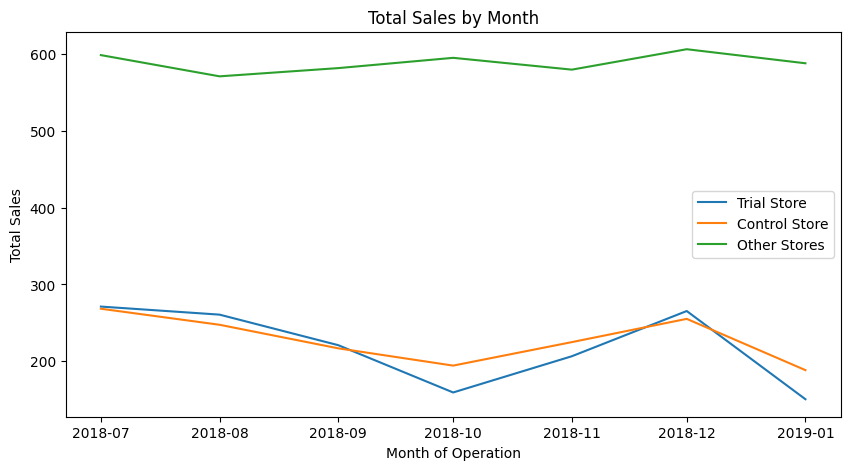

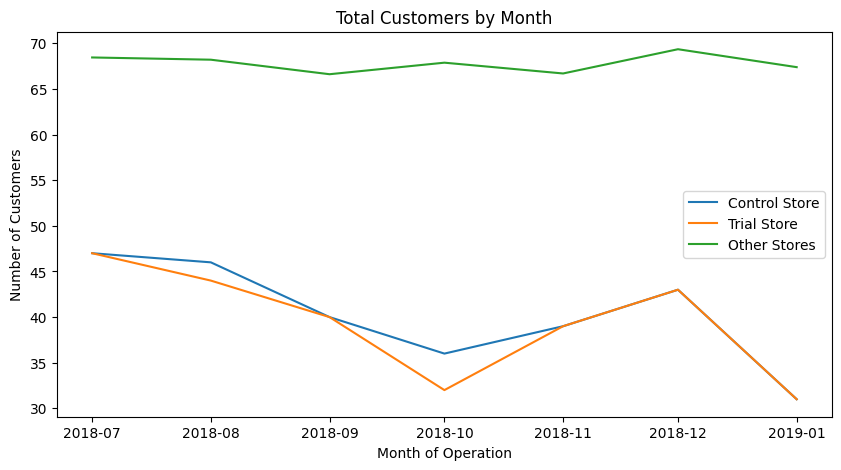

In [30]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

#### **Step C: Did the new layout in Store 77 really make sales better?**

In [31]:
# define the trial store
trial_store = 77

# Filter pre trial data for control sales and trial sales
trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store', 'totSales'].sum()

# calculate the scaling factor for control sales
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

np.float64(1.0397523623330076)

In [32]:
# filtering data only for control store 233
scaledControlSales = measureOverTime
scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]

In [33]:
# applies the 'scalingFactorSales' for control store

scaledControlSales['controlSales'] = scaledControlSales['totSales']*scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,controlSales
2695,233,2018-07,271.2,47,1.042553,1.612245,3.432911,281.980841
2696,233,2018-08,260.7,44,1.022727,1.600000,3.620833,271.063441
2697,233,2018-09,220.9,40,1.075000,1.581395,3.248529,229.681297
2698,233,2018-10,159.3,32,1.000000,1.500000,3.318750,165.632551
2699,233,2018-11,206.5,39,1.025641,1.525000,3.385246,214.708863


In [34]:
# Create new dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH','controlSales']]
percentageDiff.reset_index(drop = True,inplace =True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] ==trial_store,'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales
0,2018-07,281.980841,268.4
1,2018-08,271.063441,247.5
2,2018-09,229.681297,216.8
3,2018-10,165.632551,194.3
4,2018-11,214.708863,224.9


In [35]:
# Calculate percentage difference beetween control sales and trial sales

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales)/percentageDiff.controlSales
percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,281.980841,268.4,0.048162
1,2018-08,271.063441,247.5,0.086930
2,2018-09,229.681297,216.8,0.056083
3,2018-10,165.632551,194.3,0.173079
4,2018-11,214.708863,224.9,0.047465


In [36]:
# Calculate the standar deviation based on the scaled percentage diff in pre trial period
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.06363898833418712

In [37]:
# Find the 95th percentile of the t distribution
# define the degrees of freedom (dof = 8-1 =7)
dof =7
t.isf(0.05, dof)

np.float64(1.8945786050900066)

The numbers show that in March and April, Store 77 performed very differently from Store 233. This suggests the new layout may have actually changed how the store performed.

In [38]:
# Add a new column 'TransactionMonth' to 'scaledControlSales'

scaledControlSales['TransactionMonth'] = pd.to_datetime(scaledControlSales['YEAR_MONTH'].astype(str), format = '%Y-%m')

# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales.head()

,Control Sales
TransactionMonth,
2018-07-01,281.980841
2018-08-01,271.063441
2018-09-01,229.681297
2018-10-01,165.632551
2018-11-01,214.708863


In [39]:
# Create a new column 'TransationMonth' which convert column 'YEAR_MONTH' into datetime

measureOverTime['TransactionMonth'] = pd.to_datetime(measureOverTime['YEAR_MONTH'].astype(str), format = '%Y-%m')
measureOverTime.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
0,1,2018-07,188.9,47,1.042553,1.183673,3.256897,2018-07-01
1,1,2018-08,168.4,41,1.000000,1.268293,3.238462,2018-08-01
2,1,2018-09,268.1,57,1.035088,1.203390,3.776056,2018-09-01
3,1,2018-10,175.4,39,1.025641,1.275000,3.439216,2018-10-01
4,1,2018-11,184.8,44,1.022727,1.222222,3.360000,2018-11-01


In [40]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales.head()

,Trial Sales
TransactionMonth,
2018-07-01,268.4
2018-08-01,247.5
2018-09-01,216.8
2018-10-01,194.3
2018-11-01,224.9


In [41]:
# Create two new columns df 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,281.980841,246.090890,317.870792,268.4
2018-08-01,271.063441,236.563035,305.563847,247.5
2018-09-01,229.681297,200.447926,258.914668,216.8
2018-10-01,165.632551,144.551175,186.713927,194.3
2018-11-01,214.708863,187.381153,242.036572,224.9
2018-12-01,275.950277,240.827884,311.072670,255.2
2019-01-01,156.482731,136.565925,176.399536,188.4
2019-02-01,229.473346,200.266443,258.680250,211.6
2019-03-01,187.779277,163.879110,211.679443,255.1


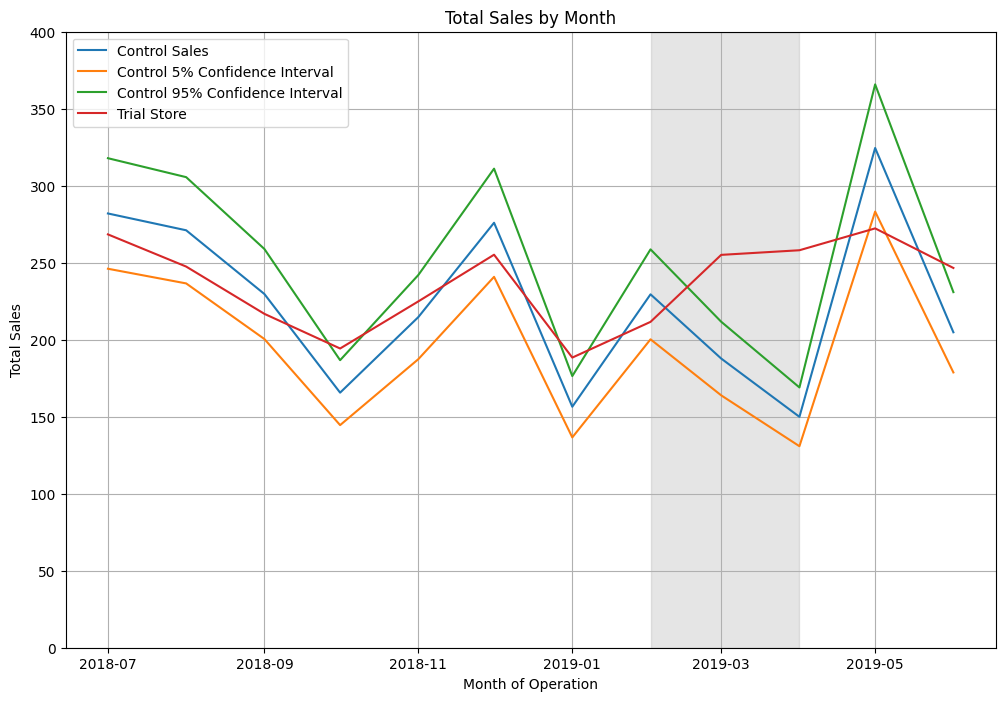

In [42]:
# visualize 'combinesales' dataframe

plt.figure(figsize = (12, 8))
plt.plot(combineSales)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Control Sales', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)
plt.ylim((0, 400))
plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)
plt.grid()
plt.show()

Store 77's performance is clearly different from Store 233 during the new layout period. In 2 out of 3 months, Store 77 performed better than what we would normally expect. This shows the new layout likely had a real positive impact!

In [43]:
# Now let's move on to 'nCustomers'
trial_customers = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type'] == 'Control Store', 'nCustomers'].sum()

# Calculate scaling factor
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

np.float64(1.0217391304347827)

In [44]:
# Filter data only for control store 233
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]

# Applies 'scalingFactorSales' to 'totSales' column
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
2695,233,2018-07,271.2,47,1.042553,1.612245,3.432911,2018-07-01,48.021739
2696,233,2018-08,260.7,44,1.022727,1.600000,3.620833,2018-08-01,44.956522
2697,233,2018-09,220.9,40,1.075000,1.581395,3.248529,2018-09-01,40.869565
2698,233,2018-10,159.3,32,1.000000,1.500000,3.318750,2018-10-01,32.695652
2699,233,2018-11,206.5,39,1.025641,1.525000,3.385246,2018-11-01,39.847826


In [45]:
# Create percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH','controlCustomers']]
percentageDiff.reset_index(drop = True , inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True , inplace = True)
percentageDiff = pd.concat([percentageDiff,trialCustomers], axis =1)
percentageDiff.rename(columns = {'nCustomers':'trialCustomers'},inplace= True)

# Calculate persentage difference and put it in a new column
percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers-percentageDiff.trialCustomers)/percentageDiff.controlCustomers
percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,48.021739,47,0.021277
1,2018-08,44.956522,46,0.023211
2,2018-09,40.869565,40,0.021277
3,2018-10,32.695652,36,0.101064
4,2018-11,39.847826,39,0.021277


In [46]:
# Our null Hipothesis is such that the trial period is the same as pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH']<'2019-02','percentageDiff'])
stdDev

0.0300435434917479

In [47]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

7     2.259470
8     9.530240
9    23.422793
Name: tValue, dtype: float64

In [48]:
# Find the 95th percentile of the t distribution with dof = 7
# Define the degrees of freeedom
# since we have 8 pre-trial months ,dof = 8 - 1 = 7
dof = 7

t.isf(0.05,7)

np.float64(1.8945786050900066)

However, we found that the number of customers visiting Store 86 was much higher than Store 155 in all three months. This is important - it shows the new layout attracted more customers even though total sales didn't increase as much!

In [49]:
# visualisation
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:,['TransactionMonth','controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers':'Control Customers'}, inplace = True)
controlCustomers.head()

,Control Customers
TransactionMonth,
2018-07-01,48.021739
2018-08-01,44.956522
2018-09-01,40.869565
2018-10-01,32.695652
2018-11-01,39.847826


In [50]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store,['TransactionMonth','nCustomers']]
trialCustomers.set_index('TransactionMonth' , inplace =True)
trialCustomers.rename(columns = {'nCustomers':'Trial Customers'}, inplace = True)
trialCustomers.head()

,Trial Customers
TransactionMonth,
2018-07-01,47
2018-08-01,46
2018-09-01,40
2018-10-01,36
2018-11-01,39


In [51]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers']*(1-stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers']*(1+stdDev*2)

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers,trialCustomers,left_index = True, right_index = True)
combineCustomers.head()

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,48.021739,45.136253,50.907226,47
2018-08-01,44.956522,42.255215,47.657828,46
2018-09-01,40.869565,38.413832,43.325298,40
2018-10-01,32.695652,30.731066,34.660239,36
2018-11-01,39.847826,37.453486,42.242166,39


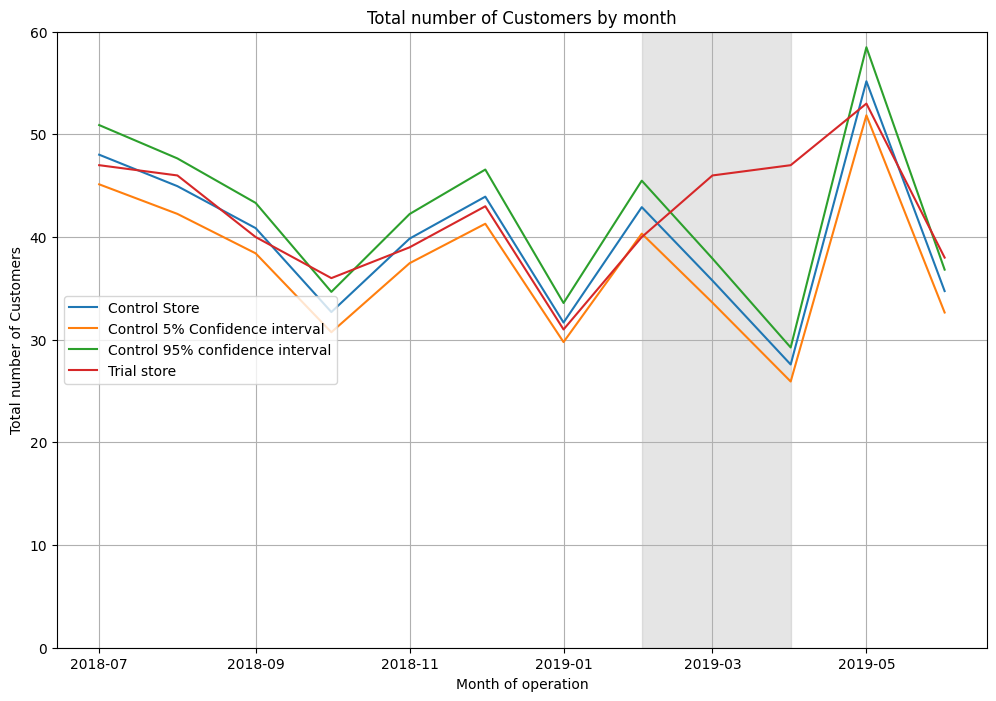

In [52]:
# Let's plot the combineCuustomers

plt.figure(figsize = (12,8))
plt.plot(combineCustomers)
plt.title('Total number of Customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of Customers')
plt.legend(['Control Store','Control 5% Confidence interval','Control 95% confidence interval','Trial store'],loc = 6)
plt.ylim((0,60))
plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color = 'grey', alpha = 0.2)
plt.grid()
plt.show()

More customers came to Store 86 during all three months of the trial. This shows the new layout successfully got people interested and coming into the store!

#### **Analysis for Trial Store 86 (Another store that got the new layout)**

In [53]:
# calculating correlation and magnitude distance between trial store 86 and other stores
trial_store = 86

# for total sales
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)

# for nCustomers
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)

In [54]:
# SCORE TOTAL SALES
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

# combined score  composed of correlation and magnitude
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
86     1          0.364734   0.488503     0.426618
       2         -0.526492   0.312655    -0.106918
       3          0.139789   0.505470     0.322630
       4          0.035618   0.563197     0.299408
       5          0.446823   0.571868     0.509346

In [55]:
# SCORE CUSTOMERS

score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()

Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
86     1          0.384379   0.583851         0.484115
       2         -0.064384   0.400000         0.167808
       3          0.063780   0.448980         0.256380
       4         -0.006242   0.576720         0.285239
       5          0.099456   0.652174         0.375815

In [56]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'

score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'

score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head(3)

scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
86     155        0.796426         0.593114           0.694770
       114        0.685930         0.668594           0.677262
       56         0.606289         0.668835           0.637562

Store 155 is the best comparison store for Store 86 because it has similar sales patterns and customer behavior.

**Step B: Comparing Store 86 with Store 155 before the layout change**

In [57]:
control_store = 155

In [58]:
pastdata = preTrialData

# Categorize data into trial store = 86, control store = 155 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == trial_store:
        store_type.append('Trial Store')
    elif i ==control_store:
        store_type.append('Control Store')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

store_type
Control Store      1
Other Stores     257
Trial Store        1
Name: STORE_NBR, dtype: int64

In [59]:
# Monthly tot sales for trial store 86
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 155
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,851.00,900.6,594.121012
2018-08-01,726.85,738.7,567.445136
2018-09-01,855.00,939.6,576.619844
2018-10-01,898.80,914.0,589.608560
2018-11-01,851.20,835.0,575.016732
2018-12-01,812.20,799.8,602.253307
2019-01-01,800.60,834.6,583.140467


In [60]:
# Visualize 'nCustomers'
# monthly total customer for trial store 77
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 233
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,94,98,68.070039
2018-08-01,92,88,67.856031
2018-09-01,100,96,66.163424
2018-10-01,105,105,67.326848
2018-11-01,95,96,66.256809
2018-12-01,93,91,68.972763
2019-01-01,89,92,66.926070


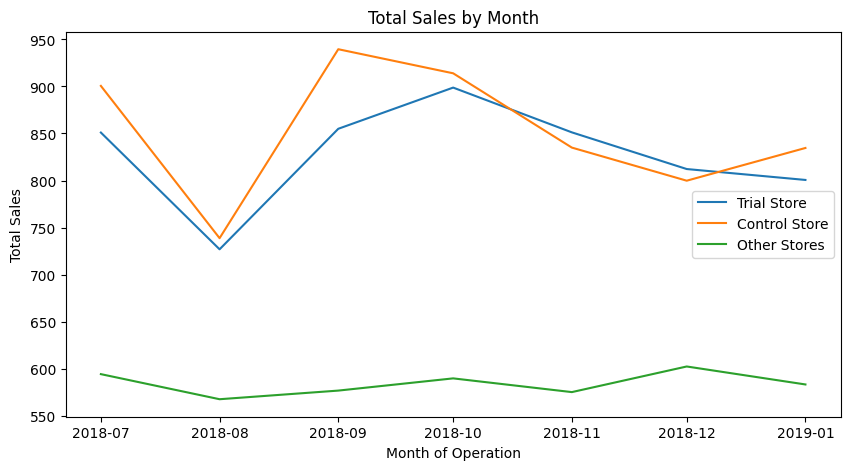

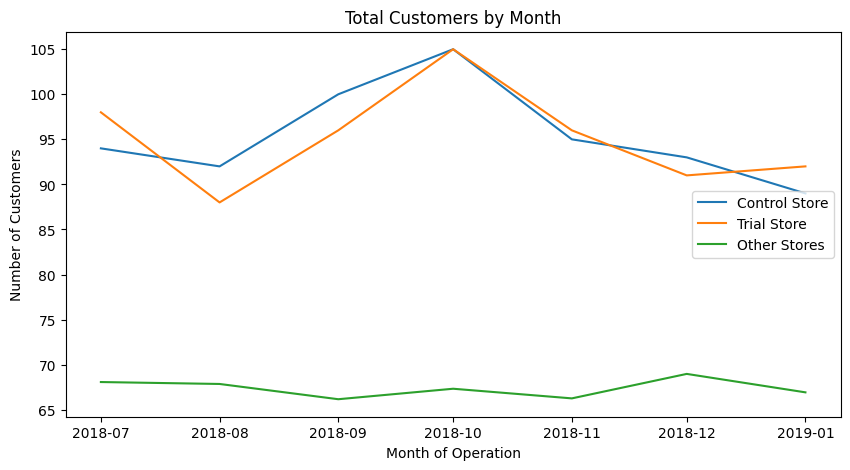

In [61]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

**Did the new layout in Store 86 help increase sales and customers?**

In [62]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for contrl store

trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store','totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store','totSales'].sum()
scalingFactorSales = trial_sum/control_sum
scalingFactorSales

np.float64(0.9720493769183033)

In [63]:
scaledControlSales = measureOverTime
# set dataframe only for control store 155

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR']==control_store]
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01


In [64]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales'] * scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlSales
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01,875.427669
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01,718.052875
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01,913.337595
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01,888.453131
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01,811.661230


In [65]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH', 'controlSales']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

In [66]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales) / percentageDiff.controlSales
percentageDiff

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,875.427669,851.00,0.027904
1,2018-08,718.052875,726.85,0.012251
2,2018-09,913.337595,855.00,0.063873
3,2018-10,888.453131,898.80,0.011646
4,2018-11,811.661230,851.20,0.048713
5,2018-12,777.445092,812.20,0.044704
6,2019-01,811.272410,800.60,0.013155
7,2019-02,827.019610,872.80,0.055356
8,2019-03,745.561872,945.40,0.268037
9,2019-04,778.028321,804.00,0.033381


In [67]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.020945888446244103

In [68]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)

In [69]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,851.00
2018-08-01,726.85
2018-09-01,855.00
2018-10-01,898.80
2018-11-01,851.20
2018-12-01,812.20
2019-01-01,800.60
2019-02-01,872.80
2019-03-01,945.40


In [70]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)
controlSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval
TransactionMonth,,,
2018-07-01,875.427669,838.754448,912.100889
2018-08-01,718.052875,687.972364,748.133386
2018-09-01,913.337595,875.076260,951.598929
2018-10-01,888.453131,851.234250,925.672011
2018-11-01,811.661230,777.659299,845.663161


In [71]:
# Merge the two dataframes together 'controlSales' and 'trialSales'
combineSales = pd.merge(controlSales,trialSales,left_index = True, right_index =True )
combineSales.head()

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,875.427669,838.754448,912.100889,851.00
2018-08-01,718.052875,687.972364,748.133386,726.85
2018-09-01,913.337595,875.076260,951.598929,855.00
2018-10-01,888.453131,851.234250,925.672011,898.80
2018-11-01,811.661230,777.659299,845.663161,851.20


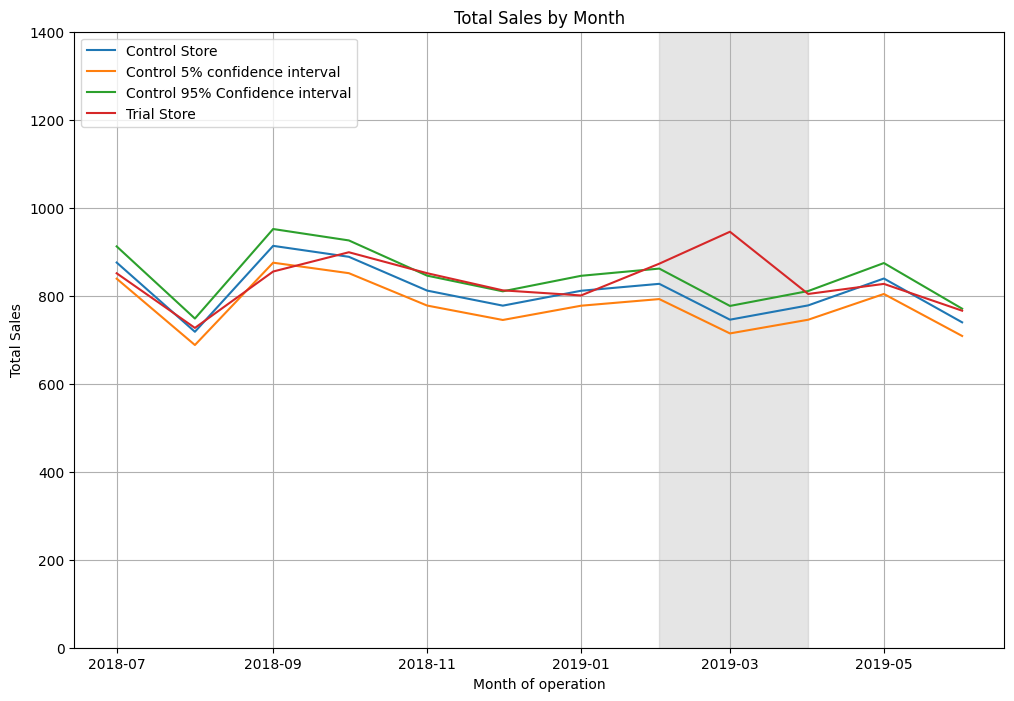

In [72]:
plt.figure(figsize =(12,8))
plt.plot(combineSales)

plt.title('Total Sales by Month')
plt.xlabel('Month of operation')
plt.ylabel('Total Sales')

plt.legend(['Control Store','Control 5% confidence interval','Control 95% Confidence interval','Trial Store'],loc = 2)

plt.ylim((0,1400))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color = 'grey',alpha=0.2)

plt.grid()
plt.show()

Store 86's sales performance during the new layout period looks similar to what Store 155 had. This suggests the new layout didn't create a big sales change in Store 86.

In [73]:
# Now let's move on to 'nCustomers'
# First, compute scaling factor

trial_customers = preTrialData.loc[preTrialData['store_type']== 'Trial Store','nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type']=='Control Store','nCustomers'].sum()
scalingFactorCustomers = trial_customers/control_customers
scalingFactorCustomers

np.float64(1.003003003003003)

In [74]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR']== control_store]
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01


In [75]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers']*scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01,98.294294
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01,88.264264
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01,96.288288
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01,105.315315
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01,96.288288


In [76]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers
0,2018-07,98.294294,94
1,2018-08,88.264264,92
2,2018-09,96.288288,100
3,2018-10,105.315315,105
4,2018-11,96.288288,95


In [77]:
# Calculate percentage difference

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers-percentageDiff.trialCustomers)/percentageDiff.controlCustomers
percentageDiff.head()

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,98.294294,94,0.043688
1,2018-08,88.264264,92,0.042324
2,2018-09,96.288288,100,0.038548
3,2018-10,105.315315,105,0.002994
4,2018-11,96.288288,95,0.013379


In [78]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation based on the scaled percentage difference in the pre-trial period

stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.016022745840356893

In [79]:
# Define the degrees of freedeom (dof = 8 - 1 =7)
dof = 7

In [80]:
# We will test with a null hypothesis of there is no difference between trial store and control store
# Create a new column for 'tvalue'

percentageDiff['tvalue'] = (percentageDiff['percentageDiff']- 0)/stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH']>'2019-01')&(percentageDiff['YEAR_MONTH']<'2019-05'),'tvalue']

7     8.605720
8    11.437481
9     3.827618
Name: tvalue, dtype: float64

In [81]:
# Find the 95th percentile of the t distribution with dof =7

t.isf(0.05,dof)

np.float64(1.8945786050900066)

However, we found that the number of customers visiting Store 86 was much higher than Store 155 in all three months. This is important - it shows the new layout attracted more customers even though total sales didn't increase as much!

In [82]:
# Time for some visualisation
# First, we need to appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:,['TransactionMonth','controlCustomers']]
controlCustomers.set_index('TransactionMonth',inplace = True)
controlCustomers.rename(columns ={'controlCustomers':'Control Customers'},inplace=True)
controlCustomers.head()

,Control Customers
TransactionMonth,
2018-07-01,98.294294
2018-08-01,88.264264
2018-09-01,96.288288
2018-10-01,105.315315
2018-11-01,96.288288


In [84]:
# Extract 'nCustomers' for trial store from ' measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR']== trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers.head()

,Trial Customers
TransactionMonth,
2018-07-01,94
2018-08-01,92
2018-09-01,100
2018-10-01,105
2018-11-01,95


In [83]:
# Create two new column under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence interval']=controlCustomers['Control Customers']*(1-stdDev*2)
controlCustomers['Control 95% Confidence interval']=controlCustomers['Control Customers']*(1+stdDev*2)
controlCustomers.head()

,Control Customers,Control 5% Confidence interval,Control 95% Confidence interval
TransactionMonth,,,
2018-07-01,98.294294,95.144405,101.444183
2018-08-01,88.264264,85.435793,91.092736
2018-09-01,96.288288,93.202683,99.373894
2018-10-01,105.315315,101.940434,108.690196
2018-11-01,96.288288,93.202683,99.373894


In [86]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers,trialCustomers,left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence interval,Control 95% Confidence interval,Trial Customers
TransactionMonth,,,,
2018-07-01,98.294294,95.144405,101.444183,94
2018-08-01,88.264264,85.435793,91.092736,92
2018-09-01,96.288288,93.202683,99.373894,100
2018-10-01,105.315315,101.940434,108.690196,105
2018-11-01,96.288288,93.202683,99.373894,95
2018-12-01,91.273273,88.348376,94.198170,93
2019-01-01,92.276276,89.319238,95.233315,89
2019-02-01,92.276276,89.319238,95.233315,105
2019-03-01,91.273273,88.348376,94.198170,108


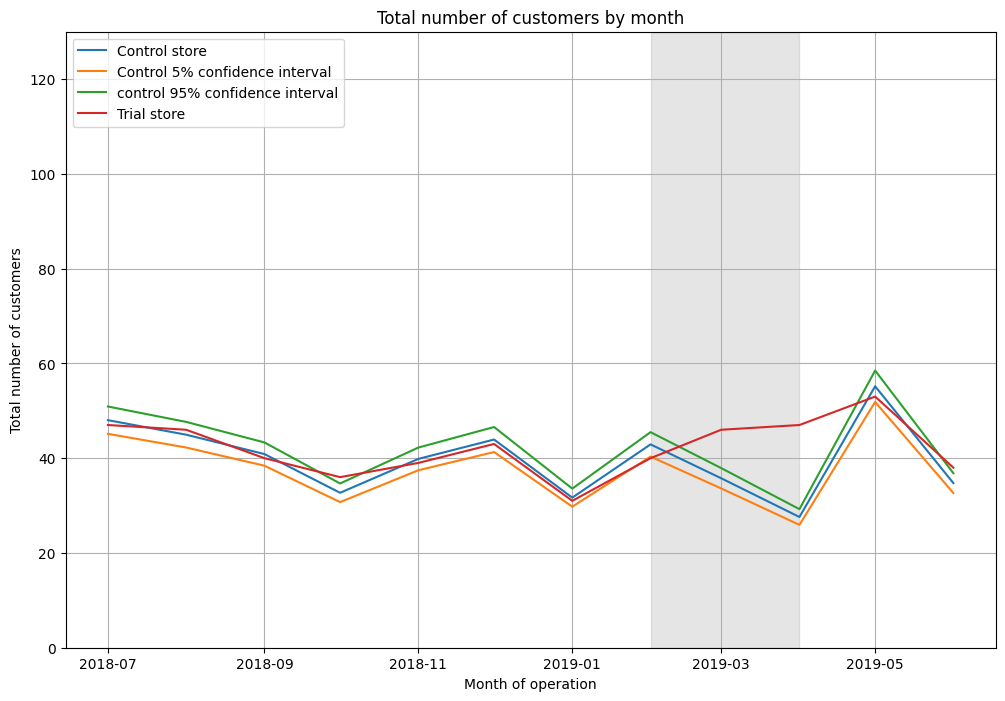

In [84]:
# Lets plot the combineCustomers
plt.figure(figsize=(12,8))
plt.plot(combineCustomers)

plt.title('Total number of customers by month')
plt.xlabel('Month of operation')
plt.ylabel('Total number of customers')

plt.legend(['Control store','Control 5% confidence interval','control 95% confidence interval','Trial store'],loc= 2)

plt.ylim((0,130))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color ='grey',alpha=0.2)

plt.grid()
plt.show()

More customers came to Store 86 during all three months of the trial. This shows the new layout successfully got people interested and coming into the store!

#### **Analysis for Trial Store 88 (The third store that got the new layout)**

In [85]:
# calculating correlation and magnitude distance between trial store 88 and other stores
trial_store = 88

# for total sales
corr_nSales = calculateCorrelation(preTrialData, 'totSales', trial_store)
magnitude_nSales = calculateMagnitudeDistance(preTrialData, 'totSales', trial_store)

# for nCustomers
corr_nCustomers = calculateCorrelation(preTrialData, 'nCustomers', trial_store)
magnitude_nCustomers = calculateMagnitudeDistance(preTrialData, 'nCustomers', trial_store)

In [86]:
# SCORE TOTAL SALES
score_nSales = pd.concat([corr_nSales, magnitude_nSales['Magnitude']], axis = 1)

# combined score  composed of correlation and magnitude
corr_weight = 0.5
score_nSales['scoreNsales'] = corr_weight * score_nSales['Correlation'] +  score_nSales['Magnitude'] *(1 - corr_weight)
score_nSales.set_index(['Store1', 'Store2'], inplace = True)
score_nSales.head()

Correlation  Magnitude  scoreNsales
Store1 Store2                                     
88     1          0.842232   0.512847     0.677540
       2         -0.232494   0.675150     0.221328
       3         -0.467330   0.433348    -0.016991
       4         -0.506130   0.468093    -0.019018
       5          0.338525   0.530793     0.434659

In [87]:
# SCORE CUSTOMERS
score_nCustomers = pd.concat([corr_nCustomers, magnitude_nCustomers['Magnitude']], axis = 1)

score_nCustomers['scoreNcustomers'] = corr_weight * score_nCustomers['Correlation'] +  score_nCustomers['Magnitude'] *(1 - corr_weight)
score_nCustomers.set_index(['Store1', 'Store2'], inplace = True)
score_nCustomers.head()

Correlation  Magnitude  scoreNcustomers
Store1 Store2                                         
88     1          0.429977   0.285714         0.357846
       2         -0.547400   0.267857        -0.139771
       3          0.434080   0.628571         0.531326
       4         -0.216778   0.579832         0.181527
       5         -0.026535   0.394558         0.184011

In [88]:
# create new dataframe contains 'scoreNSales' and 'scoreNCust'
score_Control = pd.concat([score_nSales['scoreNsales'], score_nCustomers['scoreNcustomers']], axis = 1)

# Add a new column which computes the average of 'scoreNSales' and 'scoreNCust'
score_Control['finalControlScore'] = (score_Control['scoreNsales'] + score_Control['scoreNcustomers'])/2

# top 3 final control stores
score_Control.sort_values(by = 'finalControlScore', ascending = False).head()


scoreNsales  scoreNcustomers  finalControlScore
Store1 Store2                                                 
88     14         0.582315         0.680111           0.631213
       237        0.351820         0.848496           0.600158
       204        0.754705         0.425501           0.590103
       159        0.779043         0.388366           0.583704
       134        0.646918         0.494554           0.570736

Store 237 is the best comparison store for Store 88 because it has similar sales patterns and customer behavior.

**Comparing Store 88 with Store 178 (and checking other comparison stores)**

In [89]:
pastdata = preTrialData

# Categorize data into trial store = 86, control store = 14, 134, 237 and others
store_type = []

for i in pastdata['STORE_NBR']:
    if i == 88:
        store_type.append('Trial Store')
    elif i == 178:
        store_type.append('Control Store 178')
    elif i == 14:
        store_type.append('Control Store 14')
    elif i == 134:
        store_type.append('Control Store 134')
    elif i == 237:
        store_type.append('Control Store 237')
    else :
        store_type.append('Other Stores')

pastdata['store_type']= store_type
pastdata.groupby(['store_type']).STORE_NBR.nunique()

store_type
Control Store 134      1
Control Store 14       1
Control Store 178      1
Control Store 237      1
Other Stores         254
Trial Store            1
Name: STORE_NBR, dtype: int64

In [90]:
# Monthly tot sales for trial store 88
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 178
controlSalesPlot178 = pastdata.loc[pastdata['store_type'] == 'Control Store 178', ['Transaction_Month', 'totSales']]
controlSalesPlot178.set_index('Transaction_Month', inplace = True)
controlSalesPlot178.rename(columns = {'totSales': 'Control Store 178'}, inplace = True)

# Monthly total sales for control store 14
controlSalesPlot14 = pastdata.loc[pastdata['store_type'] == 'Control Store 14', ['Transaction_Month', 'totSales']]
controlSalesPlot14.set_index('Transaction_Month', inplace = True)
controlSalesPlot14.rename(columns = {'totSales': 'Control Store 14'}, inplace = True)

# Monthly total sales for control store 134
controlSalesPlot134 = pastdata.loc[pastdata['store_type'] == 'Control Store 134', ['Transaction_Month', 'totSales']]
controlSalesPlot134.set_index('Transaction_Month', inplace = True)
controlSalesPlot134.rename(columns = {'totSales': 'Control Store 134'}, inplace = True)

# Monthly total sales for control store 237
controlSalesPlot237 = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'totSales']]
controlSalesPlot237.set_index('Transaction_Month', inplace = True)
controlSalesPlot237.rename(columns = {'totSales': 'Control Store 237'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot178, controlSalesPlot14, controlSalesPlot134,  controlSalesPlot237, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store 178,Control Store 14,Control Store 134,Control Store 237,Other Stores
Transaction_Month,,,,,,
2018-07-01,1218.2,917.6,36.7,388.60,1387.2,592.489764
2018-08-01,1242.2,832.7,46.8,417.35,1321.9,564.716535
2018-09-01,1361.8,868.8,36.9,412.80,1250.8,575.018898
2018-10-01,1270.8,892.0,42.0,463.20,1287.1,588.138189
2018-11-01,1311.4,901.4,45.0,467.60,1316.0,572.535827
2018-12-01,1213.0,903.2,24.2,352.20,1234.4,601.039764
2019-01-01,1215.4,758.4,15.0,363.80,1117.7,582.803150


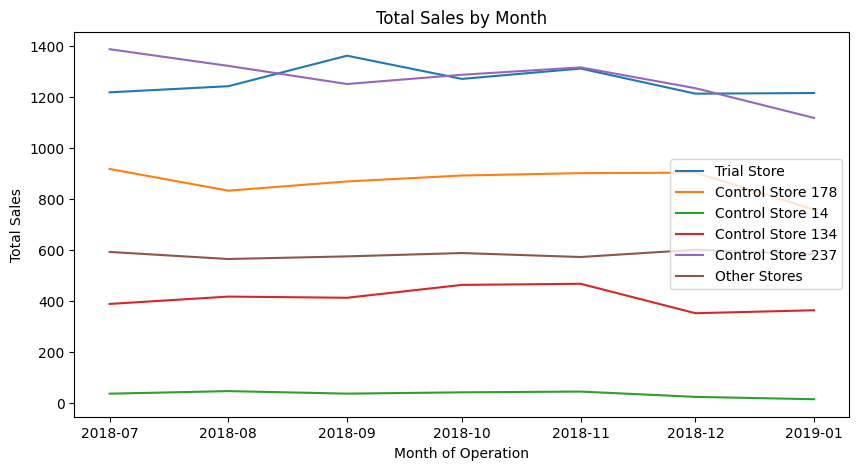

In [91]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store 178','Control Store 14','Control Store 134', 'Control Store 237', 'Other Stores'], loc = 7)


After looking at the charts, we found that Store 237 is actually a better comparison for Store 88 than the others. So we'll use Store 237 as our control store.

In [92]:
# Monthly tot sales for trial store 88
trialSalesPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'totSales']]
trialSalesPlot.set_index('Transaction_Month', inplace = True)
trialSalesPlot.rename(columns = {'totSales': 'Trial Store'}, inplace = True)

# Monthly total sales for control store 237
controlSalesPlot = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'totSales']]
controlSalesPlot.set_index('Transaction_Month', inplace = True)
controlSalesPlot.rename(columns = {'totSales': 'Control Store'}, inplace = True)

# Monthly total
otherSalesPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'totSales']]
otherSalesPlot = pd.DataFrame(otherSalesPlot.groupby('Transaction_Month').totSales.mean())
otherSalesPlot.rename(columns = {'totSales': 'Other Stores'}, inplace = True)

# Concatenate
combineSalesPlot = pd.concat([trialSalesPlot, controlSalesPlot, otherSalesPlot], axis = 1)
combineSalesPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,1218.2,1387.2,592.489764
2018-08-01,1242.2,1321.9,564.716535
2018-09-01,1361.8,1250.8,575.018898
2018-10-01,1270.8,1287.1,588.138189
2018-11-01,1311.4,1316.0,572.535827
2018-12-01,1213.0,1234.4,601.039764
2019-01-01,1215.4,1117.7,582.803150


In [93]:
# Visualize 'nCustomers'
# monthly total customer for trial store 88
trialCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Trial Store', ['Transaction_Month', 'nCustomers']]
trialCustomersPlot.set_index('Transaction_Month', inplace = True)
trialCustomersPlot.rename(columns = {'nCustomers': 'Trial Store'}, inplace = True)

# Monthly total customers fo control store 237
controlCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Control Store 237', ['Transaction_Month', 'nCustomers']]
controlCustomersPlot.set_index('Transaction_Month', inplace = True)
controlCustomersPlot.rename(columns = {'nCustomers': 'Control Store'}, inplace = True)

# Montly total customers (mean) for other stores
otherCustomersPlot = pastdata.loc[pastdata['store_type'] == 'Other Stores', ['Transaction_Month', 'nCustomers']]
otherCustomersPlot = pd.DataFrame(otherCustomersPlot.groupby('Transaction_Month').nCustomers.mean())
otherCustomersPlot.rename(columns = {'nCustomers': 'Other Stores'}, inplace = True)

# Concatenate
combineCustomersPlot = pd.concat([ trialCustomersPlot, controlCustomersPlot, otherCustomersPlot], axis = 1)
combineCustomersPlot

,Trial Store,Control Store,Other Stores
Transaction_Month,,,
2018-07-01,124,125,68.039370
2018-08-01,125,132,67.732283
2018-09-01,121,120,66.188976
2018-10-01,120,118,67.425197
2018-11-01,123,125,66.161417
2018-12-01,120,121,69.003937
2019-01-01,115,111,67.023622


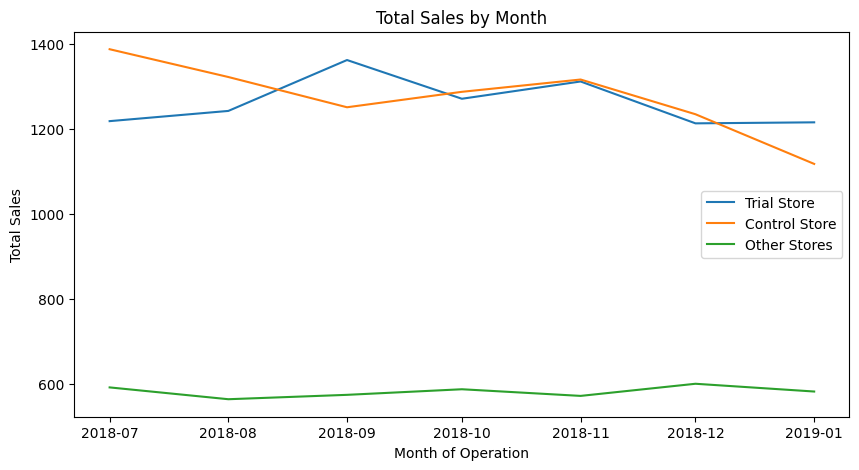

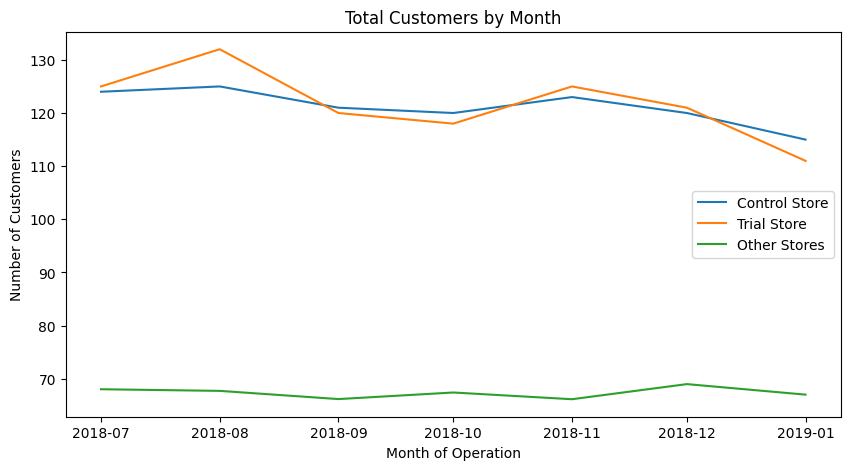

In [94]:
# Plot total sales
plt.figure(figsize = (10, 5))
plt.plot(combineSalesPlot)
plt.title('Total Sales by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Sales')
plt.legend(['Trial Store','Control Store', 'Other Stores'], loc = 7)

# Plot total number of customers
plt.figure(figsize = (10, 5))
plt.plot(combineCustomersPlot)
plt.title('Total Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.legend(['Control Store', 'Trial Store', 'Other Stores'], loc = 5)

**Did the new layout in Store 88 increase sales and customers?**

In [95]:
# First we need to work out a scaling factor to applied to the control store
# We compute this by dividing sum of 'totSales' for trial store by sum of 'totSales' for control store
# Let's call this variable 'scalingFactorSales'

trial_sum = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'totSales'].sum()
control_sum = preTrialData.loc[preTrialData['store_type'] == 'Control Store 237', 'totSales'].sum()
scalingFactorSales = trial_sum / control_sum
scalingFactorSales

np.float64(0.9907684714697534)

In [96]:
# Create a new dataframe 'scaledControlSales' and reset index

scaledControlSales = measureOverTime

In [97]:
# We only want control store i.e. store 237

scaledControlSales = scaledControlSales.loc[scaledControlSales['STORE_NBR'] == control_store]
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01


In [98]:
# Create 'controlSales' which applies 'scalingFactorSales' to 'totSales' column

scaledControlSales['controlSales'] = scaledControlSales['totSales']*scalingFactorSales
scaledControlSales.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlSales
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01,892.286085
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01,731.880670
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01,930.926056
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01,905.562383
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01,827.291674


In [99]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlSales[['YEAR_MONTH','controlSales']]
percentageDiff.reset_index(drop = True,inplace =True)

# Concatenate with trial store 'totSales'
trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] ==trial_store,'totSales']
trialSales.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialSales], axis = 1)
percentageDiff.rename(columns = {'totSales': 'trialSales'}, inplace = True)

percentageDiff

,YEAR_MONTH,controlSales,trialSales
0,2018-07,892.286085,1218.20
1,2018-08,731.880670,1242.20
2,2018-09,930.926056,1361.80
3,2018-10,905.562383,1270.80
4,2018-11,827.291674,1311.40
5,2018-12,792.416623,1213.00
6,2019-01,826.895366,1215.40
7,2019-02,842.945816,1339.60
8,2019-03,759.919418,1467.00
9,2019-04,793.011085,1317.00


In [100]:
# Calculate percentage difference

percentageDiff['percentageDiff'] = abs(percentageDiff.controlSales - percentageDiff.trialSales)/percentageDiff.controlSales
percentageDiff.head()

,YEAR_MONTH,controlSales,trialSales,percentageDiff
0,2018-07,892.286085,1218.2,0.365257
1,2018-08,731.880670,1242.2,0.697271
2,2018-09,930.926056,1361.8,0.462844
3,2018-10,905.562383,1270.8,0.403327
4,2018-11,827.291674,1311.4,0.585172


In [101]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.11319478472681974

In [102]:
# define the degrees of freedom (dof = 8-1 =7)
dof =7

In [103]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

7    5.205087
8    8.220059
9    5.837359
Name: tValue, dtype: float64

In [104]:
# Find the 95th percentile of the t distrobution with dof=7

t.isf(0.05,dof)

np.float64(1.8945786050900066)

In [105]:
# Time for some visualisation
# First we need to create the appropriate dataframe
# Extract 'controlSales' from 'scaledControlSales' dataframe for control store

controlSales = scaledControlSales.loc[:, ['TransactionMonth', 'controlSales']]
controlSales.set_index('TransactionMonth', inplace = True)
controlSales.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)
controlSales

,Control Sales
TransactionMonth,
2018-07-01,892.286085
2018-08-01,731.880670
2018-09-01,930.926056
2018-10-01,905.562383
2018-11-01,827.291674
2018-12-01,792.416623
2019-01-01,826.895366
2019-02-01,842.945816
2019-03-01,759.919418


In [106]:
# Extract 'totSales' for trial store from 'measureOverTime'

trialSales = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'totSales']]
trialSales.set_index('TransactionMonth', inplace = True)
trialSales.rename(columns = {'totSales': 'Trial Sales'}, inplace = True)
trialSales

,Trial Sales
TransactionMonth,
2018-07-01,1218.20
2018-08-01,1242.20
2018-09-01,1361.80
2018-10-01,1270.80
2018-11-01,1311.40
2018-12-01,1213.00
2019-01-01,1215.40
2019-02-01,1339.60
2019-03-01,1467.00


In [107]:
# Create two new columns under 'controlSales' which calculates the 5% and 95% confidence interval

controlSales['Control 5% Confidence Interval'] = controlSales['Control Sales'] * (1 - stdDev*2)
controlSales['Control 95% Confidence Interval'] = controlSales['Control Sales'] * (1 + stdDev*2)

In [108]:
# Merge the two dataframes together 'controlSales' and 'trialSales'

combineSales = pd.merge(controlSales, trialSales, left_index = True, right_index = True)
combineSales

,Control Sales,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Sales
TransactionMonth,,,,
2018-07-01,892.286085,690.281823,1094.290348,1218.20
2018-08-01,731.880670,566.190520,897.570820,1242.20
2018-09-01,930.926056,720.174107,1141.678005,1361.80
2018-10-01,905.562383,700.552505,1110.572261,1270.80
2018-11-01,827.291674,640.001468,1014.581879,1311.40
2018-12-01,792.416623,613.021765,971.811482,1213.00
2019-01-01,826.895366,639.694880,1014.095852,1215.40
2019-02-01,842.945816,652.111675,1033.779956,1339.60
2019-03-01,759.919418,587.881588,931.957247,1467.00


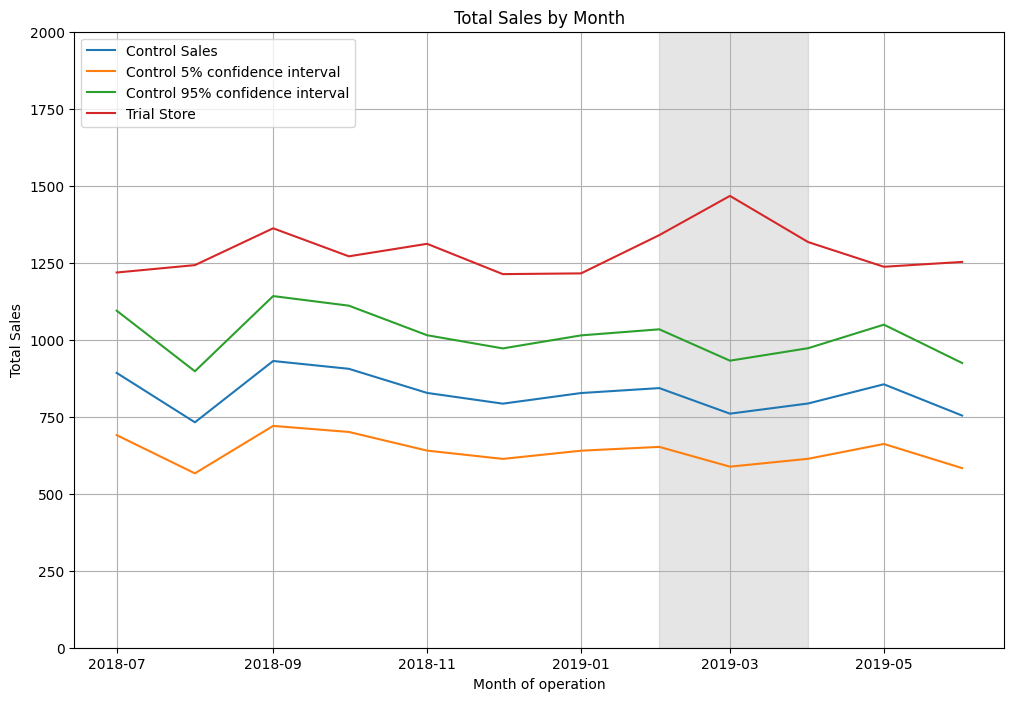

In [109]:
# Lets plot the combineSales

plt.figure(figsize=(12,8))
plt.plot(combineSales)

plt.title('Total Sales by Month')
plt.xlabel('Month of operation')
plt.ylabel('Total Sales')

plt.legend(['Control Sales','Control 5% confidence interval','Control 95% confidence interval','Trial Store'],loc = 2)

plt.ylim((0,2000))

plt.axvspan(*mdates.datestr2num(['2019-02-01','2019-04-01']),color='grey',alpha = 0.2)

plt.grid()
plt.show()

Store 88 clearly performed differently than Store 237 during the new layout trial. In 2 out of 3 months, Store 88 had definitely better sales than what we would normally expect. This shows the layout change had a real positive effect!

In [111]:
scaledControlCustomers = measureOverTime
scaledControlCustomers = scaledControlCustomers.loc[scaledControlCustomers['STORE_NBR'] == control_store]
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01


In [112]:
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorCustomers
scaledControlCustomers.head()

,STORE_NBR,YEAR_MONTH,totSales,nCustomers,ntransPerCust,nChipsPerTXN,avgPricePerUnit,TransactionMonth,controlCustomers
1792,155,2018-07,900.6,98,1.214286,2.016807,3.752500,2018-07-01,97.539906
1793,155,2018-08,738.7,88,1.284091,1.911504,3.419907,2018-08-01,87.586854
1794,155,2018-09,939.6,96,1.354167,2.015385,3.586260,2018-09-01,95.549296
1795,155,2018-10,914.0,105,1.219048,2.000000,3.570312,2018-10-01,104.507042
1796,155,2018-11,835.0,96,1.270833,2.032787,3.366935,2018-11-01,95.549296


In [113]:
# Create 'percentageDiff' dataframe
percentageDiff = scaledControlCustomers[['YEAR_MONTH', 'controlCustomers']]
percentageDiff.reset_index(drop = True, inplace = True)

# Concatenate with trial store 'nCustomers'
trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, 'nCustomers']
trialCustomers.reset_index(drop = True, inplace = True)
percentageDiff = pd.concat([percentageDiff, trialCustomers], axis = 1)
percentageDiff.rename(columns = {'nCustomers': 'trialCustomers'}, inplace = True)

percentageDiff

,YEAR_MONTH,controlCustomers,trialCustomers
0,2018-07,97.539906,124
1,2018-08,87.586854,125
2,2018-09,95.549296,121
3,2018-10,104.507042,120
4,2018-11,95.549296,123
5,2018-12,90.572770,120
6,2019-01,91.568075,115
7,2019-02,91.568075,122
8,2019-03,90.572770,133
9,2019-04,92.563380,119


In [110]:
# Now let's move on to 'nCustomers'

trial_customers = preTrialData.loc[preTrialData['store_type'] == 'Trial Store' , 'nCustomers'].sum()
control_customers = preTrialData.loc[preTrialData['store_type'] == 'Control Store 237', 'nCustomers'].sum()
scalingFactorCustomers = trial_customers / control_customers
scalingFactorCustomers

np.float64(0.9953051643192489)

In [114]:
# Calculate percentage difference and put it in a new column

percentageDiff['percentageDiff'] = abs(percentageDiff.controlCustomers - percentageDiff.trialCustomers) / percentageDiff.controlCustomers
percentageDiff

,YEAR_MONTH,controlCustomers,trialCustomers,percentageDiff
0,2018-07,97.539906,124,0.271275
1,2018-08,87.586854,125,0.427155
2,2018-09,95.549296,121,0.266362
3,2018-10,104.507042,120,0.148248
4,2018-11,95.549296,123,0.287294
5,2018-12,90.572770,120,0.324902
6,2019-01,91.568075,115,0.255896
7,2019-02,91.568075,122,0.332342
8,2019-03,90.572770,133,0.468433
9,2019-04,92.563380,119,0.285606


In [115]:
# Our null hypothesis is such that the trial period is the same as the pre-trial period
# Let's take the standard deviation
stdDev = stdev(percentageDiff.loc[percentageDiff['YEAR_MONTH'] < '2019-02', 'percentageDiff'])
stdDev

0.08352824574639295

In [116]:
# Define the degrees of freedom (dof = 8 - 1 = 7)

dof = 7

In [117]:
# We will test with a null hypothesis of there being 0 difference between trial and control stores
# Create a new column for 'tValue'

percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev
percentageDiff.loc[(percentageDiff['YEAR_MONTH'] > '2019-01') & (percentageDiff['YEAR_MONTH'] < '2019-05'), 'tValue']

7    3.978799
8    5.608073
9    3.419270
Name: tValue, dtype: float64

In [118]:
# Find the 95th percentile of the t distribution with dof = 7

t.isf(0.05, dof)

np.float64(1.8945786050900066)

All three months show that Store 88 had much higher customer numbers than Store 237. This proves the new layout successfully attracted more shoppers!

In [119]:
# visualisation
# First we need to create the appropriate dataframe
# Extract 'controlCustomers' from 'scaledControlCustomers' dataframe for control store

controlCustomers = scaledControlCustomers.loc[:, ['TransactionMonth', 'controlCustomers']]
controlCustomers.set_index('TransactionMonth', inplace = True)
controlCustomers.rename(columns = {'controlCustomers': 'Control Customers'}, inplace = True)
controlCustomers

,Control Customers
TransactionMonth,
2018-07-01,97.539906
2018-08-01,87.586854
2018-09-01,95.549296
2018-10-01,104.507042
2018-11-01,95.549296
2018-12-01,90.572770
2019-01-01,91.568075
2019-02-01,91.568075
2019-03-01,90.572770


In [120]:
# Extract 'nCustomers' for trial store from 'measureOverTime'

trialCustomers = measureOverTime.loc[measureOverTime['STORE_NBR'] == trial_store, ['TransactionMonth', 'nCustomers']]
trialCustomers.set_index('TransactionMonth', inplace = True)
trialCustomers.rename(columns = {'nCustomers': 'Trial Customers'}, inplace = True)
trialCustomers

,Trial Customers
TransactionMonth,
2018-07-01,124
2018-08-01,125
2018-09-01,121
2018-10-01,120
2018-11-01,123
2018-12-01,120
2019-01-01,115
2019-02-01,122
2019-03-01,133


In [121]:
# Create two new columns under 'controlCustomers' which calculates the 5% and 95% confidence interval

controlCustomers['Control 5% Confidence Interval'] = controlCustomers['Control Customers'] * (1 - stdDev*2)
controlCustomers['Control 95% Confidence Interval'] = controlCustomers['Control Customers'] * (1 + stdDev*2)
controlCustomers

# Merge the two dataframes together 'controlSales' and 'trialSales'

combineCustomers = pd.merge(controlCustomers, trialCustomers, left_index = True, right_index = True)
combineCustomers

,Control Customers,Control 5% Confidence Interval,Control 95% Confidence Interval,Trial Customers
TransactionMonth,,,,
2018-07-01,97.539906,81.245232,113.834581,124
2018-08-01,87.586854,72.954902,102.218807,125
2018-09-01,95.549296,79.587166,111.511426,121
2018-10-01,104.507042,87.048462,121.965622,120
2018-11-01,95.549296,79.587166,111.511426,123
2018-12-01,90.572770,75.442001,105.703539,120
2019-01-01,91.568075,76.271034,106.865116,115
2019-02-01,91.568075,76.271034,106.865116,122
2019-03-01,90.572770,75.442001,105.703539,133


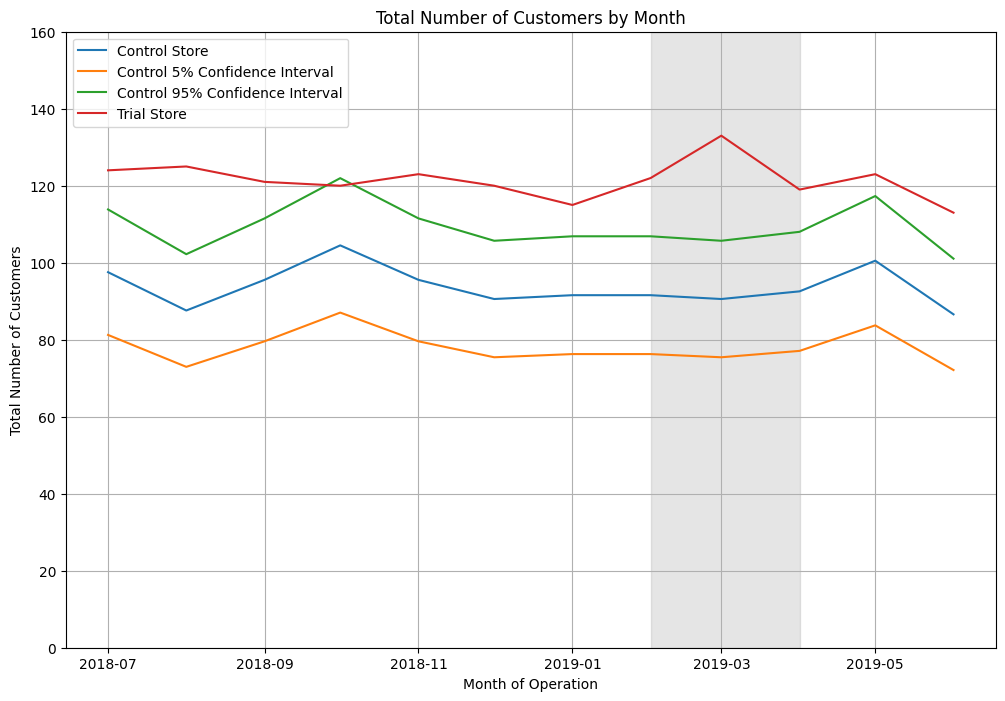

In [122]:
# Let's plot the combineCustomers
plt.figure(figsize = (12, 8))
plt.plot(combineCustomers)

plt.title('Total Number of Customers by Month')
plt.xlabel('Month of Operation')
plt.ylabel('Total Number of Customers')

plt.legend(['Control Store', 'Control 5% Confidence Interval', 'Control 95% Confidence Interval', 'Trial Store'], loc = 2)

plt.ylim((0, 160))

plt.axvspan(*mdates.datestr2num(['2019-02-01', '2019-04-01']), color = 'grey', alpha = 0.2)

plt.grid()
plt.show()

Store 88 attracted significantly more customers than Store 237 in 2 out of 3 months. This shows the new layout had a clear positive impact on bringing customers in!

**Summary of what we found:**

* **Trial Store 77** was compared with **Control Store 233** - New layout helped increase both sales and customers
* **Trial Store 86** was compared with **Control Store 155** - New layout brought in more customers even though sales stayed similar
* **Trial Store 88** was compared with **Control Store 237** - New layout helped increase both sales and customers